<a href="https://colab.research.google.com/github/Bishara10/ML-Classification-model-For-EEG-Recordings/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [26]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

fatal: destination path 'ML-Classification-model-For-EEG-Recordings' already exists and is not an empty directory.


In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import librosa
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from scipy.signal import resample, butter, filtfilt, spectrogram
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

%matplotlib notebook
%matplotlib inline


# Preprocess dataset

### Load Data

In [28]:
sampling_rate = 128 # Hertz

In [29]:
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
# print(len(file_names_adhd_dataset))
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']
# print(len(file_names_control_dataset))

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [37]:
dataADHD = []
dataControl = []
max_time_len = 44000

# Set parameters for Spectrogram
fs = 128  # Sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)

In [38]:
# filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0
    lowcut = 10.0
    highcut = 40.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [39]:
# Function to downsample the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

In [41]:
# Preprocessing for an entire recording for a patient
def preprocess_file(input_file, output_file, file_name, group_category):
  df = pd.read_csv(input_file)
  spectrograms = []

  for column in df.columns:
    #apply band pass filtering
    df[column] = bandPassFilter(df[column])
    global max_time_bins

    #apply spectrogram to each channel after it was band-pass filtered
    t, f, spctg = spectrogram(df[column], fs=fs, nperseg=nperseg, noverlap=noverlap)

    spectrograms.append(spctg)

  spectrogram_stack = np.stack(spectrograms, axis=-1)
  if group_category == 'ADHD':
    dataADHD.append(spectrogram_stack)
  elif group_category == 'CONTROL':
    dataControl.append(spectrogram_stack)

  # df.to_csv(output_file, index=False)
  print(file_name + " preprocessed successfully and saved ")

In [42]:
# Preprocess all recordings for a specific group
def preprocess_group(group_path, group_file_names, output_path, group_category):
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    preprocess_file(file_name_and_path, output_path + filename, filename, group_category)
  print("=============================== Preprocessing group successful =============================== ")

In [43]:
pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'


outputPath = '/content/preprocessed_dataset/'
try:
  os.mkdir(outputPath)
  os.mkdir(outputPath + '/ADHD/')
  os.mkdir(outputPath + '/Control/')
except FileExistsError:
  print("Folder Already exists.")

# ADHD group preprocessing
preprocess_group(pathADHD, file_names_adhd_dataset, outputPath + '/ADHD/', 'ADHD')
preprocess_group(pathControl, file_names_control_dataset, outputPath + '/Control/', 'CONTROL')


Folder Already exists.
v8p.csv preprocessed successfully and saved 
v35p.csv preprocessed successfully and saved 
v37p.csv preprocessed successfully and saved 
v36p.csv preprocessed successfully and saved 
v38p.csv preprocessed successfully and saved 
v6p.csv preprocessed successfully and saved 
v40p.csv preprocessed successfully and saved 
v39p.csv preprocessed successfully and saved 
v3p.csv preprocessed successfully and saved 
v29p.csv preprocessed successfully and saved 
v30p.csv preprocessed successfully and saved 
v31p.csv preprocessed successfully and saved 
v28p.csv preprocessed successfully and saved 
v279.csv preprocessed successfully and saved 
v33p.csv preprocessed successfully and saved 
v25p.csv preprocessed successfully and saved 
v286.csv preprocessed successfully and saved 
v250.csv preprocessed successfully and saved 
v24p.csv preprocessed successfully and saved 
v246.csv preprocessed successfully and saved 
v263.csv preprocessed successfully and saved 
v27p.csv prepr

In [44]:
len(dataADHD)

61

In [45]:
len(dataControl)

60

In [46]:
max_time_len

44000

20097


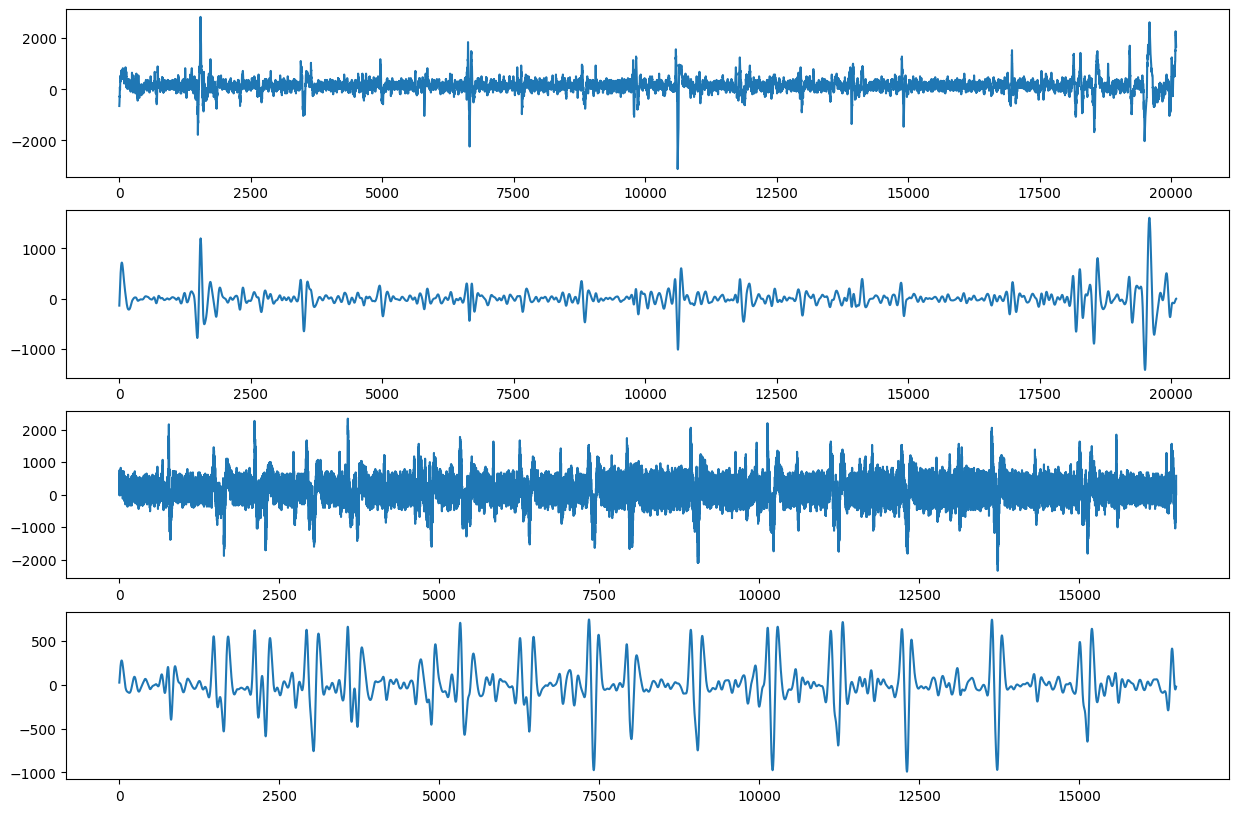

In [70]:
# Just a checkup on a random file and its processed counterpart
df = pd.read_csv(pathADHD + file_names_adhd_dataset[6])
df2 = pd.read_csv(outputPath + '/ADHD/' + file_names_adhd_dataset[6])

dfControl = pd.read_csv(pathControl + file_names_control_dataset[1])
dfControl2 = pd.read_csv(outputPath + '/Control/' + file_names_control_dataset[1])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))  # Adjust the figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes to simplify the iteration

df['0'].plot(ax = axes[0])
df2['0'].plot(ax = axes[1])

dfControl['0'].plot(ax = axes[2])
dfControl2['0'].plot(ax = axes[3])
print(len(df['1']))

# Build CNN model

### Initialising the CNN

In [24]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [25]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(freq, time, 19)))

### Step 2 - Pooling

In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [ ]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [ ]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Train / Test sets split

# MISC


In [ ]:
# Read the CSV file as a NumPy array
x = pathADHD1
data = np.loadtxt(x, delimiter=',')

# Some `information about the channels
onedata = df['0'].values.tolist()

for i in range(0, len(onedata)):
  onedata[i] = str(onedata[i])
onedata.append('0')

ch_names = onedata # TODO: finish this list

# Sampling rate of the Nautilus machine
sfreq = 128  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq)

# Finally, create the Raw object
raw = mne.io.RawArray(data, info)

# Plot it!
raw.plot()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axes = axes.flatten()
df['2'].plot(kind='line', figsize=(8, 4), title='adhd', ax=axes[0])
df2['2'].plot(kind='line', figsize=(8, 4), title='control', ax=axes[1])
plt.gca().spines[['top', 'right']].set_visible(False)
# plt.xlim([0,3000])
plt.tight_layout()
plt.show()


# Root mean suqare energy

In [ ]:
#Root mean square energy
ndarray = df['0'].to_numpy()
RMS_music = librosa.feature.rms(y=ndarray, frame_length=128, hop_length=1)
RMS_music = RMS_music[0]
# RMS_music

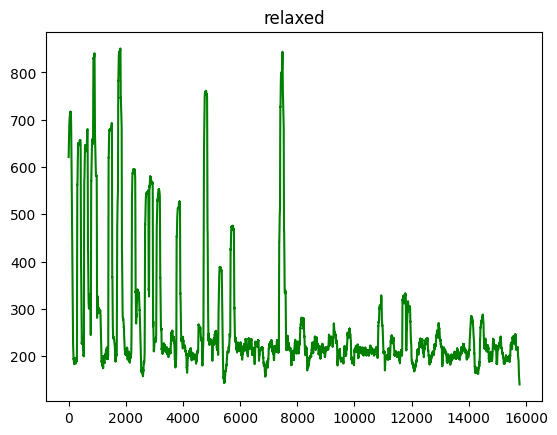

<Axes: >

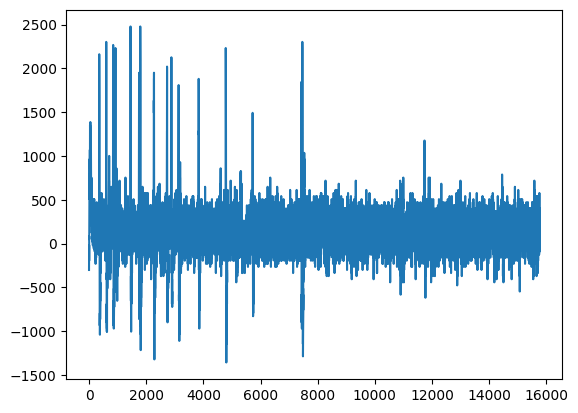

In [ ]:
frames = range(len(RMS_music))
plt.plot(frames, RMS_music, color='g')
plt.title('relaxed')
plt.show()
df['0'].plot()